# Playground - CNN used for road segmentation using PyTorch

In [8]:
# System
import os,sys
import io
import glob
import time

sys.path.append('../')
# Helper methods
from helpers.features import *
from helpers.data_helpers import *
from helpers.image_helpers import *
from helpers.helpers import *
from helpers.patched_aerial_dataset import *
from helpers.constants import *
from helpers.training import train
from helpers.mask_to_submission import generate_submission_csv
from models.rsm import Net

# ML Library
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import numpy as np
from torch.autograd import Variable

# Image processing
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

# Image augmentation
from imgaug import augmenters as iaa


#ipynb themes
from jupyterthemes import jtplot
jtplot.style()

### Train or not ?

In [11]:
TRAIN = True

### Load the data

In [15]:
transform = transforms.ToTensor()

if TRAIN : 
    
    permutation = True
    
    if permutation:
        #Note : doing really bad on validation bad since I've added the permutations
        indexes = np.random.permutation(np.arange(1, DATA_SIZE+ 1,1))
        indexes_train = indexes[:TRAINING_SIZE]
        indexes_valid = indexes[TRAINING_SIZE:]
    else:
        # No permutation :
        indexes = np.arange(1, DATA_SIZE+ 1,1)
        indexes_train = indexes[:TRAINING_SIZE]
        indexes_valid = indexes[TRAINING_SIZE:]


    #Note : aug4 good 79% peak flip up/left
    #Note : aug7 good 78% peak contours
    #Note : aug9 good 79% peak flip up/left roate -45/+45
    #Note : aug7 + aug9 good 78% peak flip up/left roate -45/+45 + contours

    print("Training data " + '=' * 100)
    trainset = PatchedAerialDataset(TRAIN_IMAGE_DATA,
                             TRAIN_LABEL_DATA,
                             indexes_train, 
                             IMG_PATCH_SIZE,
                             transform,
                             train=TRAIN)#,
                             #augment=[TRAINING_DIR + 'images_aug7/', TRAINING_DIR + 'images_aug9/'])
    
    print("Validation data "+ '=' * 100)
    validationset = PatchedAerialDataset(TRAIN_IMAGE_DATA, TRAIN_LABEL_DATA, indexes_valid, IMG_PATCH_SIZE, transform, validation=True, train=TRAIN)

    trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=5)
    validationloader = DataLoader(validationset, batch_size=BATCH_SIZE, shuffle=False, num_workers=5)

    
# #Test data for predictions
# print("Test data" + '=' * 100)
# indexes_test = np.arange(1, TESTING_SIZE+ 1,1)
# testset = PatchedAerialDataset(TEST_IMAGE_DATA, TEST_LABEL_DATA, indexes_test, IMG_PATCH_SIZE, transform, train=TRAIN)
# testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=5)  
# print(indexes_test)
# print(len(testset))


Training data ====================================================================================================

Loading 80 aerial images: 99, 18, 14, 50, 65, 38, 3, 59, 73, 83, 37, 60, 68, 35, 4, 44, 66, 76, 6, 69, 12, 95, 79, 1, 29, 88, 2, 25, 20, 100, 32, 41, 13, 94, 5, 61, 16, 33, 53, 15, 64, 97, 17, 89, 90, 80, 70, 78, 27, 22, 42, 46, 72, 91, 9, 7, 96, 93, 92, 19, 81, 86, 10, 11, 48, 24, 82, 30, 40, 39, 57, 21, 75, 67, 54, 71, 85, 43, 45, 63,  done.

Loading 80 aerial labels: 99, 18, 14, 50, 65, 38, 3, 59, 73, 83, 37, 60, 68, 35, 4, 44, 66, 76, 6, 69, 12, 95, 79, 1, 29, 88, 2, 25, 20, 100, 32, 41, 13, 94, 5, 61, 16, 33, 53, 15, 64, 97, 17, 89, 90, 80, 70, 78, 27, 22, 42, 46, 72, 91, 9, 7, 96, 93, 92, 19, 81, 86, 10, 11, 48, 24, 82, 30, 40, 39, 57, 21, 75, 67, 54, 71, 85, 43, 45, 63,  done.
Validation data ====================================================================================================

Loading 20 aerial images: 84, 62, 74, 26, 23, 31, 98, 36, 87, 47, 49, 77,

In [18]:
# Initializing the model
CUDA = True
rsn = Net().cuda(1)
# if CUDA: rsn.cuda(1)

if TRAIN:
    # Training the model
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(rsn.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
    # Train the model (optionnaly compare to GT using gt data)
    accuracy = train(rsn, trainloader, criterion, optimizer, threshold=0.80, validationloader=validationloader)
    # Save model locally
    torch.save(rsn.state_dict(), PATH_TO_CHECKPOINTS + 'model_' + time.strftime("%d-%m-%Y") + '.pt')
else:
    # Loading lastest model
    latest_checkpoint = max(glob.glob(PATH_TO_CHECKPOINTS + '*'), key=os.path.getctime)
    rsn.load_state_dict(torch.load(latest_checkpoint))

Learning Rate ; 0.01


RuntimeError: expected CPU tensor (got CUDA tensor)

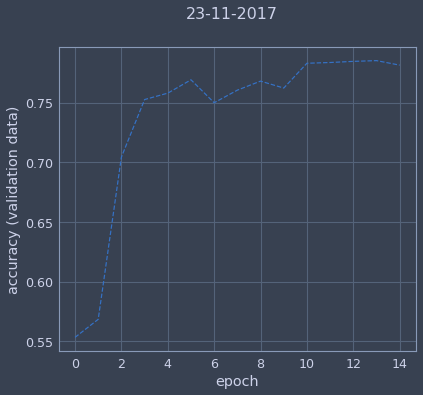

In [5]:
# Print accuracy curve
fig = plt.figure()
x = np.arange(0, NUM_EPOCHS)
plt.plot(x, accuracy, '--')
fig.suptitle(time.strftime("%d-%m-%Y" ))

plt.xlabel('epoch')
plt.ylabel('accuracy (validation data)')
plt.savefig('./plots/epoch_accuracy' + time.strftime("%d-%m-%Y-%h-%s") + '.png', dpi=fig.dpi)
plt.show()

# NOTE : this tells us that we should have stop at 10-30 epochs

### Get labels for test data

In [11]:
predicted_labels = []
# By batch loader
i = 0
for data in testloader:
    i = i+1
    patches, _ = data
    

    if CUDA:
        patches = patches.cuda(1)
    
    # Feed the neural net with the patches
    outputs = rsn(Variable(patches))
    _, predicted = torch.max(outputs.data, 1)
    predicted_labels.append(predicted)
print(i)

3356


### Generate images for submission


In [13]:
# Flatten the labels to dimension 1x72200
print(len(predicted_labels))
predicted_labels_flat = torch.cat(predicted_labels).cpu().numpy()
print(len(predicted_labels_flat))
# See ./helpers/image_helpers.py
generate_predictions(predicted_labels_flat, concatenate = False)

3356
53686


AssertionError: 

### Generate csv for submission

In [ ]:
# See ./helpers/mask_to_submission.py
generate_submission_csv()